In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

import altair as alt
alt.renderers.enable("notebook")

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import mean_squared_error

In [2]:
chicago_trips = pd.read_csv('../Data/taxi_model_sample0001.csv')

In [3]:
chicago_trips.sample(5)

,trip_id,trip_seconds,pickup_community_area,dropoff_community_area,fare,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,year,month,day,week_day,hour,minute,distance_miles,distance_ord,distance_mdw,taxi_id_ind
23114,4536775619ce46e92d9e350616d41f27418356d9,600,28,8,9.00,Cash,Dispatch Taxi Affiliation,41.885300,-87.642808,41.895033,-87.619711,82.0,1005.0,290.770,few clouds,240.0,3.0,2016,6,6,2,12,15,1.733317,19.228525,10.221773,8
3015,f47863fd60b4c27d0d06c61d0ea16a5146959810,1740,32,7,18.65,Cash,Choice Taxi Association,41.880994,-87.632746,41.929078,-87.646293,89.0,1020.0,278.370,light rain,229.0,3.0,2013,12,27,6,20,30,3.450067,18.200005,10.561540,853
4775,37d5b41df06529ed9b782ca1512e0a16afd77472,1620,76,6,30.05,Cash,Choice Taxi Association,41.979071,-87.903040,41.942692,-87.651771,75.0,1002.0,280.650,light rain,180.0,5.0,2014,3,27,5,22,45,17.561080,0.120623,12.863130,795
13619,0897d1ec9725e2b52333fb01c99b87b391ebb6a1,1740,8,5,15.65,Cash,Taxi Affiliation Services,41.899602,-87.633308,41.947792,-87.683835,87.0,1029.0,275.435,broken clouds,199.0,3.0,2015,3,10,3,17,45,4.825825,15.426429,11.375130,1831
3569,3b0bfd0adeee6035e4205949be68868689f582f1,480,8,8,6.85,Cash,Dispatch Taxi Affiliation,41.891972,-87.612945,41.893216,-87.637844,91.0,1014.0,267.090,sky is clear,292.0,1.0,2014,1,31,6,9,0,1.724412,19.379112,10.844393,49


In [4]:
chicago_trips.dtypes

trip_id                        object
trip_seconds                    int64
pickup_community_area           int64
dropoff_community_area          int64
fare                          float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
humidity                      float64
pressure                      float64
temperature                   float64
weather_description            object
wind_direction                float64
wind_speed                    float64
year                            int64
month                           int64
day                             int64
week_day                        int64
hour                            int64
minute                          int64
distance_miles                float64
distance_ord                  float64
distance_mdw                  float64
taxi_id_ind 

In [5]:
chicago_trips = chicago_trips.drop(['trip_id','trip_seconds'],axis=1)

In [6]:
chicago_trips = pd.get_dummies(chicago_trips)

In [7]:
chicago_train = chicago_trips[(chicago_trips['year']<2016)] # |
                             #((chicago_trips['year']==2016) & (chicago_trips['month']<=6))]

In [8]:
chicago_train.shape

(20346, 154)

In [9]:
chicago_test_val = chicago_trips[(chicago_trips['year']>=2016)] # |
                             #((chicago_trips['year']==2016) & (chicago_trips['month']>6))]

In [10]:
chicago_test_val.shape

(5803, 154)

In [11]:
chicago_validation = chicago_test_val.sample(frac=0.5,random_state=13)
chicago_test = chicago_test_val.sample(frac=0.5,random_state=42)

In [12]:
train_target = chicago_train[['fare']]
train_predictors = chicago_train.drop(['fare'],axis=1)

In [13]:
validation_target = chicago_validation[['fare']]
validation_predictors = chicago_validation.drop(['fare'],axis=1)

In [14]:
del chicago_trips,chicago_train,chicago_test_val,chicago_validation

In [15]:
def rmse(target,predictors):
    return sqrt(mean_squared_error(target, predictors))

## LINEAL REGRESSION

%%time
taxi_model_lin_reg = LinearRegression()
taxi_model_lin_reg.fit(train_predictors, train_target)

train_predictions = taxi_model_lin_reg.predict(train_predictors)
val_predictions = taxi_model_lin_reg.predict(validation_predictors)

error_train = rmse(train_target, train_predictions)
error_val = rmse(validation_target, val_predictions)
difference = error_val - error_train
print ('The RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (error_train,error_val,difference))

## DECISION TREE

In [17]:
%%time
dicc_dt={}
for depth in range(1,20):
    taxi_model = DecisionTreeRegressor(max_depth=depth,
                                       random_state=13)
    taxi_model.fit(train_predictors, train_target)
    train_predictions = taxi_model.predict(train_predictors)
    val_predictions = taxi_model.predict(validation_predictors)
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    dicc_dt[str(depth)]= [error_train,error_val,difference]
    print ('For a %d depth the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (depth,error_train,error_val,difference)) 

For a 1 depth the RMSE_train is 4.46961 $, the RMSE_val is 5.76210 $ and the difference 1.29249 $
For a 2 depth the RMSE_train is 3.25930 $, the RMSE_val is 4.46609 $ and the difference 1.20679 $
For a 3 depth the RMSE_train is 2.81862 $, the RMSE_val is 4.14319 $ and the difference 1.32456 $
For a 4 depth the RMSE_train is 2.63206 $, the RMSE_val is 3.95211 $ and the difference 1.32004 $
For a 5 depth the RMSE_train is 2.42593 $, the RMSE_val is 3.80559 $ and the difference 1.37966 $
For a 6 depth the RMSE_train is 2.31309 $, the RMSE_val is 3.77509 $ and the difference 1.46200 $
For a 7 depth the RMSE_train is 2.22016 $, the RMSE_val is 3.82136 $ and the difference 1.60121 $
For a 8 depth the RMSE_train is 2.10932 $, the RMSE_val is 3.82705 $ and the difference 1.71774 $
For a 9 depth the RMSE_train is 2.01310 $, the RMSE_val is 3.86572 $ and the difference 1.85263 $
For a 10 depth the RMSE_train is 1.83580 $, the RMSE_val is 3.91242 $ and the difference 2.07662 $
For a 11 depth the 

In [18]:
min(dicc_dt.items(), key=lambda x: x[1][0])

('19', [0.7367061178968115, 4.262172105279589, 3.525465987382778])

In [19]:
min(dicc_dt.items(), key=lambda x: x[1][1])

('6', [2.313094211112164, 3.7750921676115676, 1.4619979564994035])

In [20]:
min(dicc_dt.items(), key=lambda x: x[1][2])

('2', [3.2593016908662746, 4.466093525642854, 1.206791834776579])

## RANDOM FORREST

In [ ]:
%%time
dicc_rf={}
for depth in range(2,11):
    print('Depth: %d' % (depth))
    for estimator in range (50,151,5):
        for leaves in [50,100,200,500,1000,5000]:
            #print('Estimator: %d' % (estimator))
            taxi_model_rf = RandomForestRegressor(n_estimators=estimator,
                                                  max_depth=depth,
                                                  max_leaf_nodes=leaves,
                                                  n_jobs=-1)
            taxi_model_rf.fit(train_predictors, train_target)                                    
            train_predictions = taxi_model.predict(train_predictors)
            val_predictions = taxi_model.predict(validation_predictors)
            error_train = rmse(train_target, train_predictions)
            error_val = rmse(validation_target, val_predictions)
            difference = error_val - error_train
            dicc_rf[str(depth) + '_' + str(estimator)+'_'+str(leaves)]= [error_train,error_val,difference]
            print ('For a %d estimators and %d leaves the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (estimator,leaves,error_train,error_val,difference))  
            
            

Depth: 2


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 3


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 4


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 7


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 8


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 9


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 110 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 115 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 120 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 125 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 130 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 135 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 140 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 145 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 150 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $
Depth: 10


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 50 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 55 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 60 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 65 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 70 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 75 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 80 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 85 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 90 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 95 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 200 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 500 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 1000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 100 estimators and 5000 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 50 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


For a 105 estimators and 100 leaves the RMSE_train is 1.00103 $, the RMSE_val is 3.73132 $ and the difference 2.73029 $


In [ ]:
min(dicc_rf.items(), key=lambda x: x[1][0])

In [ ]:
min(dicc_rf.items(), key=lambda x: x[1][1])

In [ ]:
min(dicc_rf.items(), key=lambda x: x[1][2])

## XGBOOST

In [21]:
%%time
dicc_xgb={}
for depth in range(2,13):
    print('Depth: %d' % (depth))
    
    taxi_model = XGBRegressor(max_depth=depth,
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  n_jobs=-1)
    
    taxi_model.fit(train_predictors,
                       train_target,
                       early_stopping_rounds=5,
                       eval_set=[(validation_predictors, validation_target)],
                       verbose=False)
    
    train_predictions = taxi_model.predict(train_predictors)
    val_predictions = taxi_model.predict(validation_predictors)
    
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
    
    dicc_xgb[str(depth) + '_' + str(100)]= [error_train,error_val,difference]
    print ('For a 100 estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (error_train,error_val,difference))

Depth: 2
For a 100 estimators the RMSE_train is 2.40181 $, the RMSE_val is 3.84337 $ and the difference 1.44156 $
Depth: 3
For a 100 estimators the RMSE_train is 2.25755 $, the RMSE_val is 3.76785 $ and the difference 1.51030 $
Depth: 4
For a 100 estimators the RMSE_train is 2.11946 $, the RMSE_val is 3.72915 $ and the difference 1.60969 $
Depth: 5
For a 100 estimators the RMSE_train is 1.96826 $, the RMSE_val is 3.72536 $ and the difference 1.75710 $
Depth: 6
For a 100 estimators the RMSE_train is 1.78913 $, the RMSE_val is 3.71020 $ and the difference 1.92107 $
Depth: 7
For a 100 estimators the RMSE_train is 1.64818 $, the RMSE_val is 3.71680 $ and the difference 2.06862 $
Depth: 8
For a 100 estimators the RMSE_train is 1.43396 $, the RMSE_val is 3.73023 $ and the difference 2.29627 $
Depth: 9
For a 100 estimators the RMSE_train is 1.26767 $, the RMSE_val is 3.72398 $ and the difference 2.45631 $
Depth: 10
For a 100 estimators the RMSE_train is 1.07742 $, the RMSE_val is 3.74689 $ an

In [26]:
%%time
dicc_xgb={}
for depth in range(3,11):
    print('Depth: %d' % (depth))
    
    for estimator in range (50,301,40):
        taxi_model = XGBRegressor(max_depth=depth,
                                  learning_rate=0.1,
                                  n_estimators=estimator,
                                  n_jobs=-1)
        
        taxi_model.fit(train_predictors,
                       train_target,
                       early_stopping_rounds=5,
                       eval_set=[(validation_predictors, validation_target)],
                       verbose=False)
        
        train_predictions = taxi_model.predict(train_predictors)
        val_predictions = taxi_model.predict(validation_predictors)
        
        error_train = rmse(train_target, train_predictions)
        error_val = rmse(validation_target, val_predictions)
        difference = error_val - error_train
        
        dicc_xgb[str(depth) + '_' + str(estimator)]= [error_train,error_val,difference]
        
        print ('For a %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (estimator,error_train,error_val,difference))       

Depth: 3
For a 50 estimators the RMSE_train is 2.35146 $, the RMSE_val is 3.88662 $ and the difference 1.53516 $
For a 90 estimators the RMSE_train is 2.27298 $, the RMSE_val is 3.78227 $ and the difference 1.50929 $
For a 130 estimators the RMSE_train is 2.22477 $, the RMSE_val is 3.74233 $ and the difference 1.51756 $
For a 170 estimators the RMSE_train is 2.19852 $, the RMSE_val is 3.71915 $ and the difference 1.52063 $
For a 210 estimators the RMSE_train is 2.19852 $, the RMSE_val is 3.71915 $ and the difference 1.52063 $
For a 250 estimators the RMSE_train is 2.19852 $, the RMSE_val is 3.71915 $ and the difference 1.52063 $
For a 290 estimators the RMSE_train is 2.19852 $, the RMSE_val is 3.71915 $ and the difference 1.52063 $
Depth: 4
For a 50 estimators the RMSE_train is 2.24432 $, the RMSE_val is 3.84367 $ and the difference 1.59935 $
For a 90 estimators the RMSE_train is 2.13946 $, the RMSE_val is 3.73885 $ and the difference 1.59939 $
For a 130 estimators the RMSE_train is 2.

In [27]:
min(dicc_xgb.items(), key=lambda x: x[1][0])

('10_130', [1.077424619554028, 3.7468865111302034, 2.6694618915761756])

In [28]:
min(dicc_xgb.items(), key=lambda x: x[1][1])

('6_130', [1.7328353202347326, 3.700474318446497, 1.9676389982117644])

In [29]:
min(dicc_xgb.items(), key=lambda x: x[1][2])

('3_90', [2.2729764918402893, 3.7822665285314323, 1.509290036691143])

In [ ]:
xgb_df = pd.DataFrame.from_dict(dicc_xgb).T
xgb_df.columns=['error_train','error_val','difference']
xgb_df.head()

In [ ]:
ax = xgb_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=12, rot=0)
ax.set_title('RMSE $', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

## ADABOOST

In [48]:
%%time
dicc_adab={}
for estimator in range (1,51,1):
    taxi_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=6),
                                    loss='exponential',
                                    n_estimators=estimator)
    taxi_model.fit(train_predictors,train_target)
        
    train_predictions = taxi_model.predict(train_predictors)
    val_predictions = taxi_model.predict(validation_predictors)
        
    error_train = rmse(train_target, train_predictions)
    error_val = rmse(validation_target, val_predictions)
    difference = error_val - error_train
        
    dicc_adab[loss_type + '_' + str(estimator)]= [error_train,error_val,difference]
        
    print ('For a %d loss the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the difference %.5f $'
               % (estimator,error_train,error_val,difference))       

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 1 loss the RMSE_train is 2.42338 $, the RMSE_val is 3.84924 $ and the difference 1.42586 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 2 loss the RMSE_train is 2.46749 $, the RMSE_val is 4.08792 $ and the difference 1.62043 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 3 loss the RMSE_train is 2.28255 $, the RMSE_val is 3.91574 $ and the difference 1.63319 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 4 loss the RMSE_train is 2.28890 $, the RMSE_val is 3.88569 $ and the difference 1.59679 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 5 loss the RMSE_train is 2.26032 $, the RMSE_val is 3.78208 $ and the difference 1.52176 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 6 loss the RMSE_train is 2.24942 $, the RMSE_val is 3.73271 $ and the difference 1.48329 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 7 loss the RMSE_train is 2.27487 $, the RMSE_val is 3.73425 $ and the difference 1.45938 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 8 loss the RMSE_train is 2.30302 $, the RMSE_val is 3.73290 $ and the difference 1.42987 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 9 loss the RMSE_train is 2.24281 $, the RMSE_val is 3.79492 $ and the difference 1.55212 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 10 loss the RMSE_train is 2.31680 $, the RMSE_val is 3.75511 $ and the difference 1.43831 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 11 loss the RMSE_train is 2.39535 $, the RMSE_val is 3.75974 $ and the difference 1.36438 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 12 loss the RMSE_train is 2.32631 $, the RMSE_val is 3.72331 $ and the difference 1.39700 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 13 loss the RMSE_train is 2.42129 $, the RMSE_val is 3.75014 $ and the difference 1.32885 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 14 loss the RMSE_train is 2.49676 $, the RMSE_val is 3.78089 $ and the difference 1.28413 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 15 loss the RMSE_train is 2.49112 $, the RMSE_val is 3.76262 $ and the difference 1.27149 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 16 loss the RMSE_train is 2.53694 $, the RMSE_val is 3.69223 $ and the difference 1.15529 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 17 loss the RMSE_train is 2.71761 $, the RMSE_val is 3.80267 $ and the difference 1.08506 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 18 loss the RMSE_train is 2.66644 $, the RMSE_val is 3.86498 $ and the difference 1.19854 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 19 loss the RMSE_train is 2.71760 $, the RMSE_val is 3.80100 $ and the difference 1.08340 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 20 loss the RMSE_train is 2.74322 $, the RMSE_val is 3.77128 $ and the difference 1.02805 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 21 loss the RMSE_train is 2.79953 $, the RMSE_val is 3.88412 $ and the difference 1.08458 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 22 loss the RMSE_train is 2.80766 $, the RMSE_val is 3.82881 $ and the difference 1.02116 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 23 loss the RMSE_train is 2.76821 $, the RMSE_val is 3.83177 $ and the difference 1.06356 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 24 loss the RMSE_train is 2.91243 $, the RMSE_val is 3.86569 $ and the difference 0.95326 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 25 loss the RMSE_train is 2.77635 $, the RMSE_val is 3.80956 $ and the difference 1.03321 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 26 loss the RMSE_train is 2.97969 $, the RMSE_val is 3.89568 $ and the difference 0.91598 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 27 loss the RMSE_train is 2.90926 $, the RMSE_val is 3.91576 $ and the difference 1.00650 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 28 loss the RMSE_train is 3.04420 $, the RMSE_val is 3.83759 $ and the difference 0.79340 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 29 loss the RMSE_train is 3.16391 $, the RMSE_val is 3.99983 $ and the difference 0.83592 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 30 loss the RMSE_train is 2.86291 $, the RMSE_val is 3.85101 $ and the difference 0.98810 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 31 loss the RMSE_train is 3.25113 $, the RMSE_val is 4.01028 $ and the difference 0.75914 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 32 loss the RMSE_train is 3.07338 $, the RMSE_val is 3.93349 $ and the difference 0.86010 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 33 loss the RMSE_train is 3.17326 $, the RMSE_val is 3.95198 $ and the difference 0.77871 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 34 loss the RMSE_train is 3.33525 $, the RMSE_val is 4.08150 $ and the difference 0.74625 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 35 loss the RMSE_train is 3.15825 $, the RMSE_val is 3.99938 $ and the difference 0.84112 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 36 loss the RMSE_train is 3.13707 $, the RMSE_val is 3.89780 $ and the difference 0.76073 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 37 loss the RMSE_train is 3.14071 $, the RMSE_val is 4.06211 $ and the difference 0.92140 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 38 loss the RMSE_train is 3.17953 $, the RMSE_val is 4.00703 $ and the difference 0.82750 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 39 loss the RMSE_train is 3.20061 $, the RMSE_val is 3.89705 $ and the difference 0.69644 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 40 loss the RMSE_train is 3.05853 $, the RMSE_val is 3.87170 $ and the difference 0.81317 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 41 loss the RMSE_train is 3.50832 $, the RMSE_val is 4.19993 $ and the difference 0.69161 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 42 loss the RMSE_train is 3.31788 $, the RMSE_val is 4.05710 $ and the difference 0.73922 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 43 loss the RMSE_train is 3.48136 $, the RMSE_val is 4.14268 $ and the difference 0.66132 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 44 loss the RMSE_train is 3.26624 $, the RMSE_val is 4.03220 $ and the difference 0.76596 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 45 loss the RMSE_train is 3.14111 $, the RMSE_val is 3.88882 $ and the difference 0.74771 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 46 loss the RMSE_train is 3.61159 $, the RMSE_val is 4.26744 $ and the difference 0.65585 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 47 loss the RMSE_train is 3.50809 $, the RMSE_val is 4.12325 $ and the difference 0.61516 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 48 loss the RMSE_train is 3.20834 $, the RMSE_val is 3.88995 $ and the difference 0.68161 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 49 loss the RMSE_train is 3.36686 $, the RMSE_val is 3.95288 $ and the difference 0.58601 $


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For a 50 loss the RMSE_train is 3.52423 $, the RMSE_val is 4.16981 $ and the difference 0.64558 $
CPU times: user 4min 12s, sys: 2.13 s, total: 4min 15s
Wall time: 4min 15s


In [49]:
min(dicc_adab.items(), key=lambda x: x[1][0])

('exponential_9', [2.2428083997746944, 3.79492478699524, 1.5521163872205457])

In [50]:
min(dicc_adab.items(), key=lambda x: x[1][1])

('exponential_16',
 [2.5369440434607196, 3.6922309289136184, 1.1552868854528988])

In [51]:
min(dicc_adab.items(), key=lambda x: x[1][2])

('exponential_49', [3.366864662638434, 3.952877887872074, 0.5860132252336401])

In [54]:
adab_df = pd.DataFrame.from_dict(dicc_adab).T
adab_df.columns=['error_train','error_val','difference']

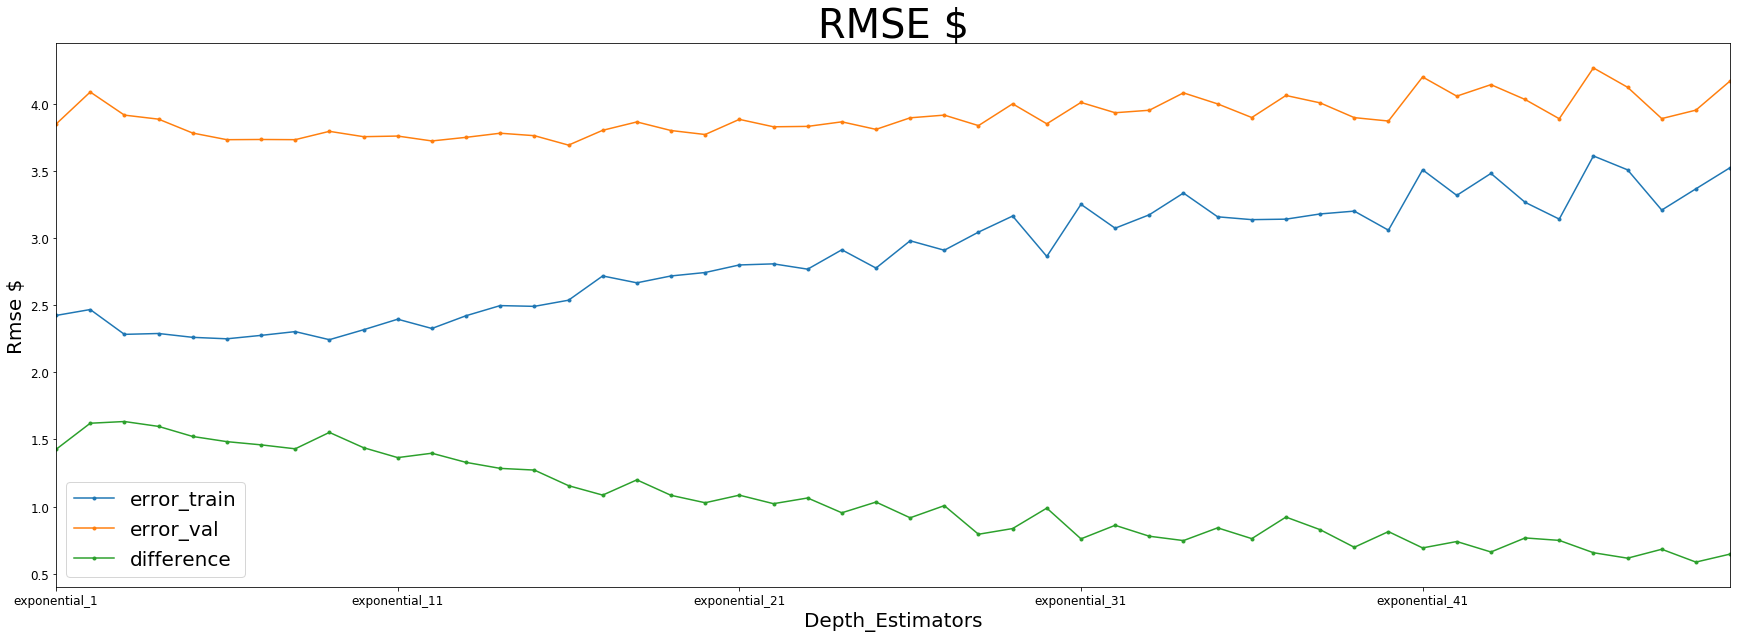

In [53]:
ax = adab_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=12, rot=0)
ax.set_title('RMSE $', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

In [30]:
xgb_df = pd.DataFrame.from_dict(dicc_xgb).T
xgb_df.columns=['error_train','error_val','difference']
xgb_df.head()

,error_train,error_val,difference
2_100,2.499606,2.910899,0.411293
2_105,2.489003,2.879968,0.390965
2_110,2.477463,2.858537,0.381074
2_115,2.466242,2.833289,0.367047
2_120,2.459117,2.819246,0.360129


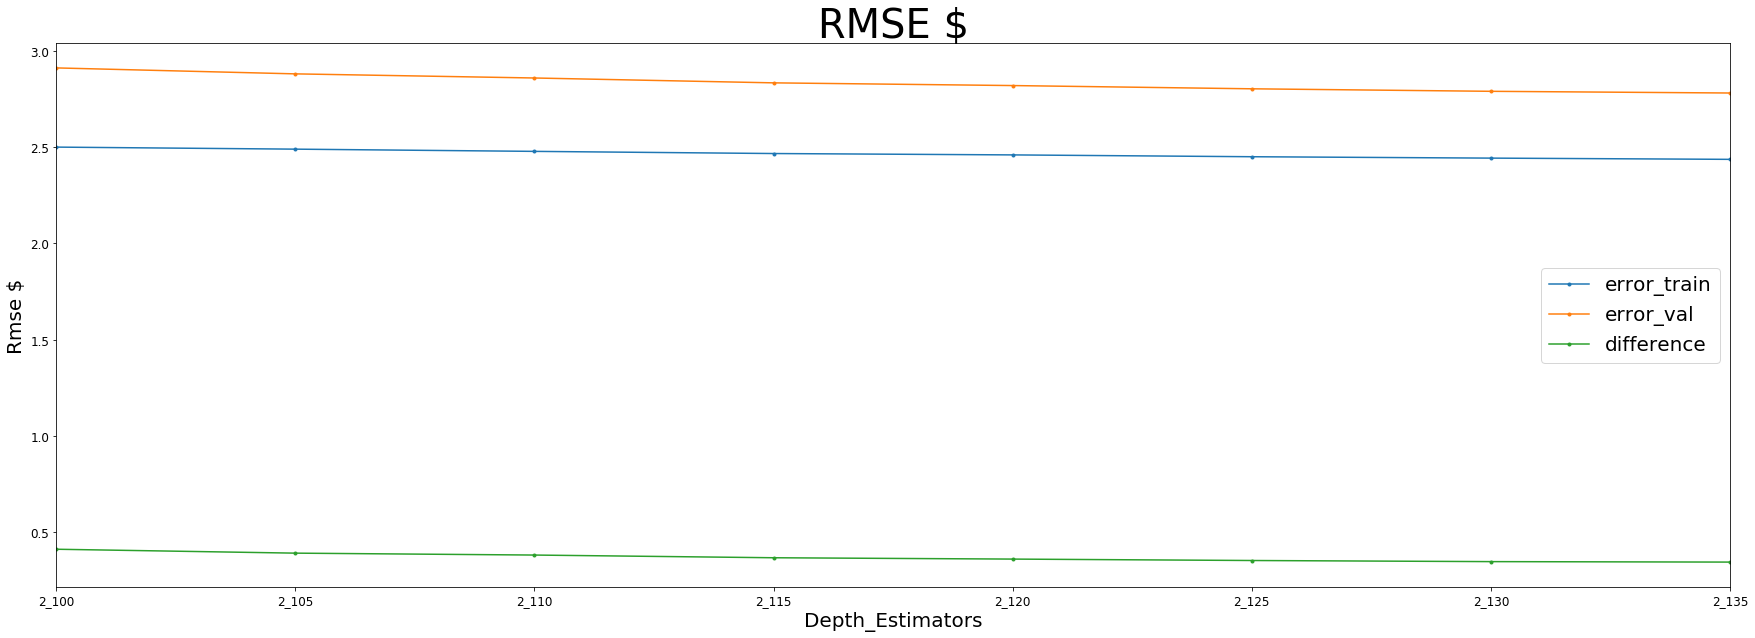

In [31]:
ax = xgb_df.plot(kind='line', style='.-',figsize=(30, 10),fontsize=12, rot=0)
ax.set_title('RMSE $', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

alt.Chart(xgb_df.reset_index()).mark_line().encode(x ='index',
                                     y="error_train",
                                    color='difference')

In [26]:
ax = xgb_df.loc['2_190':'5_190',:].plot(kind='line', style='D-',figsize=(20, 10),fontsize=12, rot=0)
ax.set_title('RMSE $ (Detail between depth 2 and 5)', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

KeyError: '5_190'

In [ ]:
ax = xgb_det.loc[:,'error_train':'error_val'].plot(kind='line', style='D-',figsize=(20, 10),fontsize=12, rot=0)
ax.set_title('RMSE $', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

In [ ]:
ax = xgb_df.loc['2_190':'5_190','error_train':'error_val']\
           .plot(kind='line', style='D-',figsize=(20, 10),fontsize=12, rot=0)
ax.set_title('RMSE $ (Detail between depth 2 and 5)', fontsize=40)
ax.set_xlabel("Depth_Estimators", fontsize=20)
ax.set_ylabel("Rmse $", fontsize=20)
ax.legend(fontsize=20)

plt.show()

In [78]:
test_target = chicago_test[['fare']]
test_predictors = chicago_test.drop(['fare'],axis=1)

In [81]:
taxi_model = XGBRegressor(max_depth=3,
                          learning_rate=0.05,
                          n_estimators=estimator,
                          n_jobs=-1)

taxi_model.fit(train_predictors,train_target,early_stopping_rounds=5,
               eval_set=[(validation_predictors, validation_target)],
               verbose=False)

train_predictions = taxi_model.predict(train_predictors)
val_predictions = taxi_model.predict(validation_predictors)
test_predictions = taxi_model.predict(test_predictors)

error_train = rmse(train_target, train_predictions)
error_val = rmse(validation_target, val_predictions)
error_test = rmse(test_target, test_predictions)

print ('For a %d estimators the RMSE_train is %.5f $, the RMSE_val is %.5f $ and the RMSE_test %.5f $'
               % (estimator,error_train,error_val,error_test))

For a 135 estimators the RMSE_train is 2.25065 $, the RMSE_val is 2.38898 $ and the RMSE_test 2.45100 $
For a 140 estimators the RMSE_train is 2.24511 $, the RMSE_val is 2.38101 $ and the RMSE_test 2.44341 $
For a 145 estimators the RMSE_train is 2.24068 $, the RMSE_val is 2.37747 $ and the RMSE_test 2.43734 $
For a 150 estimators the RMSE_train is 2.23599 $, the RMSE_val is 2.37123 $ and the RMSE_test 2.43122 $
For a 155 estimators the RMSE_train is 2.23230 $, the RMSE_val is 2.36826 $ and the RMSE_test 2.42790 $
